# EDA Classification

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

Exploratory Data Analysis (EDA) is one of the techniques used for extracting vital features and trends used by machine learning and deep learning models in Data Science. Thus, EDA has become an important milestone for anyone working in data science.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [5]:
df = pd.read_csv('credit_risk.csv')

This dataset is about the credit risk.

In [6]:
X_cols = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 
          'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

y_col = ['loan_status']

### ii. Drop 'y' NaNs

In [7]:
df = df[df[y_col[0]].notna()]

# 2. EDA

### i. Split

How we don't have temporal dependency the split is the classical.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df[X_cols].copy()
y = df[y_col[0]].copy()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

### ii. Numerical and categorical

In [11]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']
num_zero = ['cb_person_cred_hist_length']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

### iii. FillNaNs

In [12]:
num_mean_ave = X_train[num_mean].mean()
num_mean_nan_ave = X_train[num_mean_nan].mean()

In [13]:
X_train[cat_str] = X_train[cat_str].fillna('UNKOWN')
X_train[cat_oh] = X_train[cat_oh].fillna('UNKOWN')

X_train[num_mean] = X_train[num_mean].fillna(num_mean_ave)
X_train[num_zero] = X_train[num_zero].fillna(0)

X_train[num_mean_nan] = X_train[num_mean_nan].fillna(num_mean_nan_ave)
X_train[num_zero_nan] = X_train[num_zero_nan].fillna(0)

### iv. Analysis "y" variable

In [14]:
y_train.value_counts()

0    15278
1     4270
Name: loan_status, dtype: int64

In [15]:
round(y_train.value_counts(normalize = True)*100, 2)

0    78.16
1    21.84
Name: loan_status, dtype: float64

**Comments:** The problem is slightly unbalanced.

### v. Relation dependent variable with independent: Numerical (ANOVA)

In [16]:
num_X_cols = num_mean + num_zero + num_mean_nan + num_zero_nan

In [17]:
def anova_test(name_num_col):

    f_0 = (y_train == 0)
    f_1 = (y_train == 1)

    S_0 = X_train[f_0][name_num_col].std()
    S_1 = X_train[f_1][name_num_col].std()

    n_0 = f_0.sum()
    n_1 = f_1.sum()

    n_T = len(y_train)

    bar_x = X_train[name_num_col].mean()

    bar_x_0 = X_train[f_0][name_num_col].mean()
    bar_x_1 = X_train[f_1][name_num_col].mean()

    SS_W = (n_0 - 1)*(S_0**2) + (n_1 - 1)*(S_1**2)
    SS_B = n_0*((bar_x - bar_x_0)**2) + n_1*((bar_x - bar_x_1)**2)

    MS_W = SS_W/(n_T - 2)
    MS_B = SS_B/(2 - 1)

    F_stat = MS_B/MS_W

    cdf = scipy.stats.f.cdf(F_stat, 2 - 1, n_T - 2)
    p_value = 1 - cdf

    return F_stat, p_value

In [18]:
dict_anova = {}

for name_num_col in num_X_cols:

    F_col, p_col = anova_test(name_num_col)

    dict_anova[name_num_col] = {}
    dict_anova[name_num_col]['F'] = F_col
    dict_anova[name_num_col]['p_value'] = p_col*100

In [19]:
for k_anova in dict_anova.keys():
    print('Numerical column:', k_anova)
    print(dict_anova[k_anova])
    print('-'*70)

Numerical column: person_age
{'F': 5.89152274498991, 'p_value': 1.522291301410672}
----------------------------------------------------------------------
Numerical column: person_income
{'F': 555.5803720664836, 'p_value': 1.1102230246251565e-14}
----------------------------------------------------------------------
Numerical column: loan_percent_income
{'F': 3207.083218966495, 'p_value': 1.1102230246251565e-14}
----------------------------------------------------------------------
Numerical column: cb_person_cred_hist_length
{'F': 1.6773584410227746, 'p_value': 19.52911204904244}
----------------------------------------------------------------------
Numerical column: loan_int_rate
{'F': 2177.437627268028, 'p_value': 1.1102230246251565e-14}
----------------------------------------------------------------------
Numerical column: person_emp_length
{'F': 143.2165788854713, 'p_value': 1.1102230246251565e-14}
----------------------------------------------------------------------
Numerical co

### vi. Relation dependent variable with independent: Categorical (Chi-Test)

In [20]:
cat_X_cols = cat_str + cat_oh

In [21]:
df_train = pd.concat([X_train, y_train], axis = 1)

In [22]:
def chi_test(name_cat_col_1, name_cat_col_2):

    #------------------------------------------------------------------------------------------

    value_counts_p_1 = df_train[name_cat_col_1].value_counts(normalize = True)
    keys_p_1 = list(value_counts_p_1.keys())

    dict_p_1 = {}

    for k_1 in keys_p_1:
        dict_p_1[k_1] = value_counts_p_1[k_1]

    #------------------------------------------------------------------------------------------

    value_counts_p_2 = df_train[name_cat_col_2].value_counts(normalize = True)
    keys_p_2 = list(value_counts_p_2.keys())

    dict_p_2 = {}

    for k_2 in keys_p_2:
        dict_p_2[k_2] = value_counts_p_2[k_2]

    #------------------------------------------------------------------------------------------

    observed = {}
    expected = {}

    N = len(df_train)

    T = 0

    for k_1 in keys_p_1:
        for k_2 in keys_p_2:

            new_key = str(k_1) + '_' + str(k_2)

            observed[new_key] = ((df_train[name_cat_col_1] == k_1) & (df_train[name_cat_col_2] == k_2)).sum()
            expected[new_key] = dict_p_1[k_1]*dict_p_2[k_2]*N

            T = T + ((observed[new_key] - expected[new_key])**2)/expected[new_key]

    #------------------------------------------------------------------------------------------

    k = (len(keys_p_1) - 1)*(len(keys_p_2) - 1)

    cdf = scipy.stats.chi2.cdf(T, df = k)

    p_value = 1 - cdf

    return T, p_value

In [23]:
dict_chi = {}

for c_X_cols in cat_X_cols:
    dict_chi[c_X_cols] = {}
    dict_chi[c_X_cols]['T'] = chi_test('loan_status', c_X_cols)[0]
    dict_chi[c_X_cols]['p'] = chi_test('loan_status', c_X_cols)[1]*100

In [24]:
for k_chi in dict_chi.keys():
    print('Categorical column:', k_chi)
    print('T:', dict_chi[k_chi]['T'])
    print('p_value:', dict_chi[k_chi]['p'])
    print('-'*70)

Categorical column: person_home_ownership
T: 1133.3001241251043
p_value: 0.0
----------------------------------------------------------------------
Categorical column: loan_intent
T: 315.1047799478533
p_value: 0.0
----------------------------------------------------------------------
Categorical column: cb_person_default_on_file
T: 601.265495671789
p_value: 0.0
----------------------------------------------------------------------
Categorical column: loan_grade
T: 3370.001876411037
p_value: 0.0
----------------------------------------------------------------------


### vii. Plot the relation between dependent and independent variables: Numerical

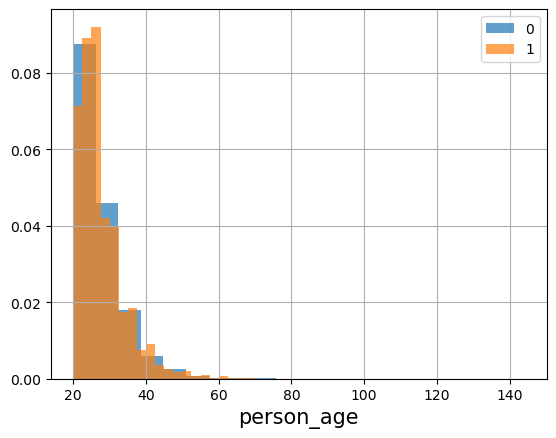

----------------------------------------------------------------------


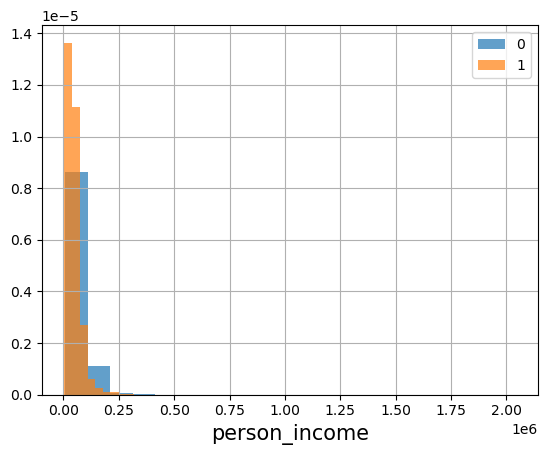

----------------------------------------------------------------------


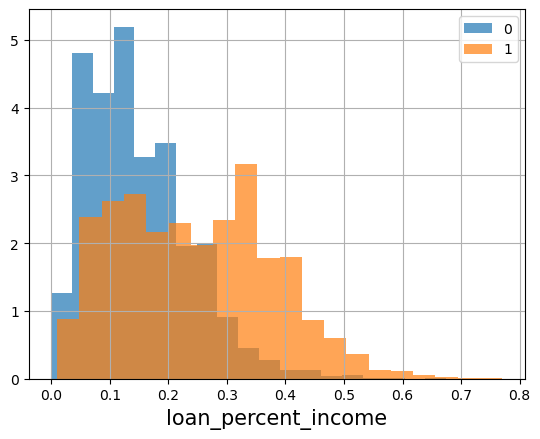

----------------------------------------------------------------------


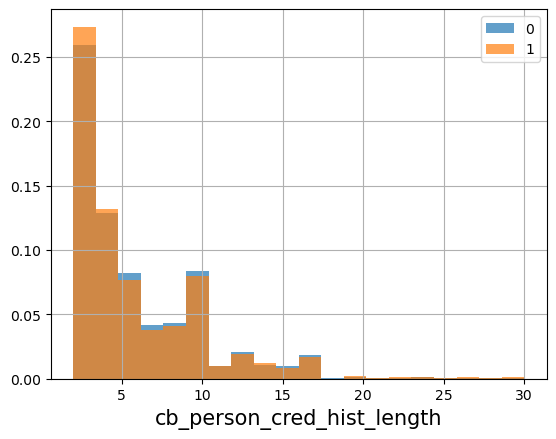

----------------------------------------------------------------------


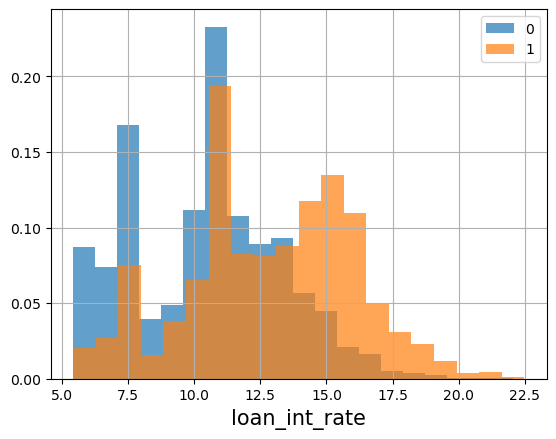

----------------------------------------------------------------------


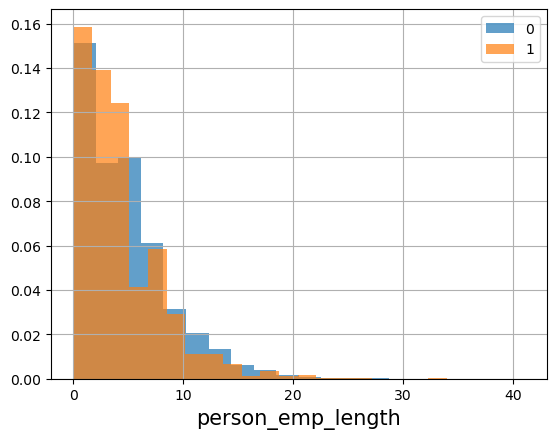

----------------------------------------------------------------------


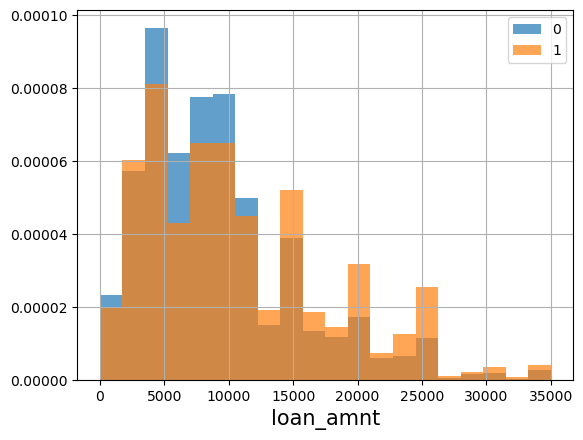

----------------------------------------------------------------------


In [25]:
for name_num_col in num_X_cols:

    df_train[df_train['loan_status'] == 0][name_num_col].hist(density = True, alpha = 0.7, label = '0', bins = 20)
    df_train[df_train['loan_status'] == 1][name_num_col].hist(density = True, alpha = 0.7, label = '1', bins = 20)
    plt.xlabel(name_num_col, fontsize = 15)
    plt.legend()
    plt.show()

    print('-'*70)

### viii. Plot the relation between dependent and independent variables: Categorical

In [26]:
for c_X_cols in cat_X_cols:

    print('\n')
    print(f'General: {c_X_cols}')
    print('\n')

    print(round(df_train[c_X_cols].value_counts(normalize = True)*100, 2))

    print('-'*70)

    print('\n')
    print('Label: 0')
    print('\n')

    print(round(df_train[df_train['loan_status'] == 0][c_X_cols].value_counts(normalize = True)*100, 2))

    print('-'*70)

    print('\n')
    print('Label: 1')
    print('\n')

    print(round(df_train[df_train['loan_status'] == 1][c_X_cols].value_counts(normalize = True)*100, 2))

    print('-'*70)
    print('-'*70)
    print('-'*70)



General: person_home_ownership


RENT        50.62
MORTGAGE    41.00
OWN          8.04
OTHER        0.34
Name: person_home_ownership, dtype: float64
----------------------------------------------------------------------


Label: 0


MORTGAGE    45.82
RENT        44.36
OWN          9.52
OTHER        0.29
Name: person_home_ownership, dtype: float64
----------------------------------------------------------------------


Label: 1


RENT        73.00
MORTGAGE    23.75
OWN          2.74
OTHER        0.52
Name: person_home_ownership, dtype: float64
----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------


General: loan_intent


EDUCATION            19.70
MEDICAL              19.04
VENTURE              17.36
PERSONAL             16.90
DEBTCONSOLIDATION    15.98
HOMEIMPROVEMENT      11.02
Name: loan_intent, dtype: float64
---------------

### ix. Patterns of interest

* Loan Status vs Loan Grade

### x. Plotting every independent variable: Numerical

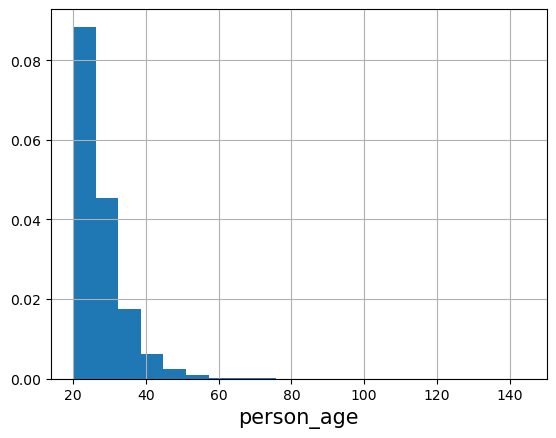

----------------------------------------------------------------------


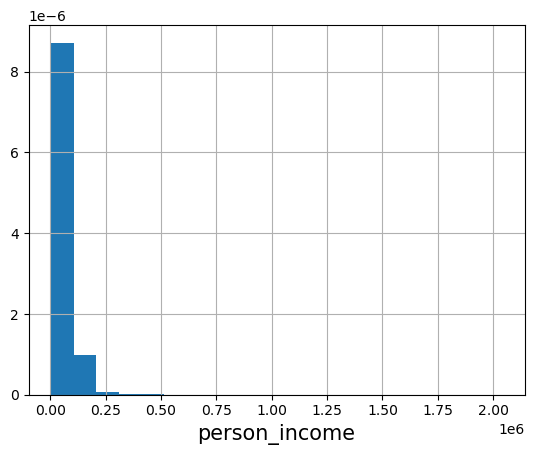

----------------------------------------------------------------------


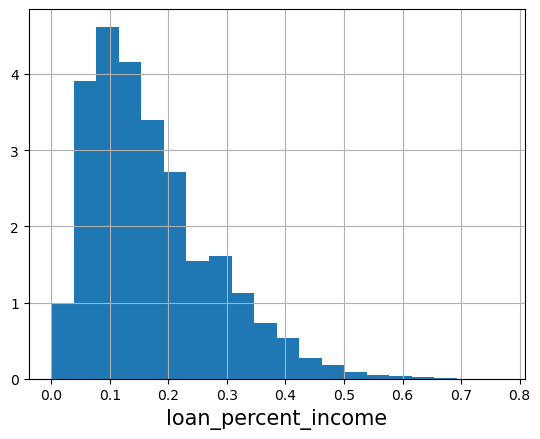

----------------------------------------------------------------------


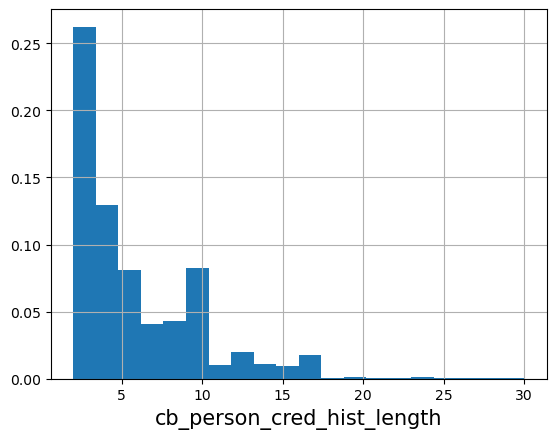

----------------------------------------------------------------------


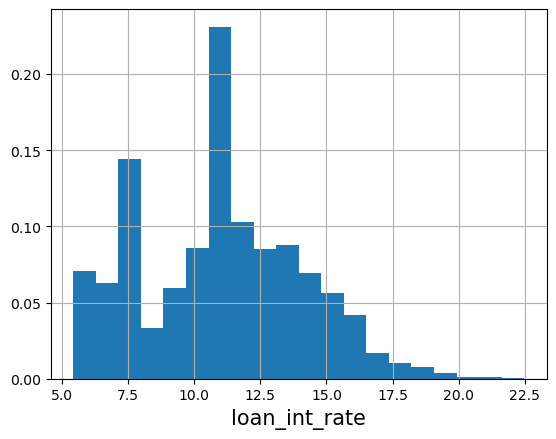

----------------------------------------------------------------------


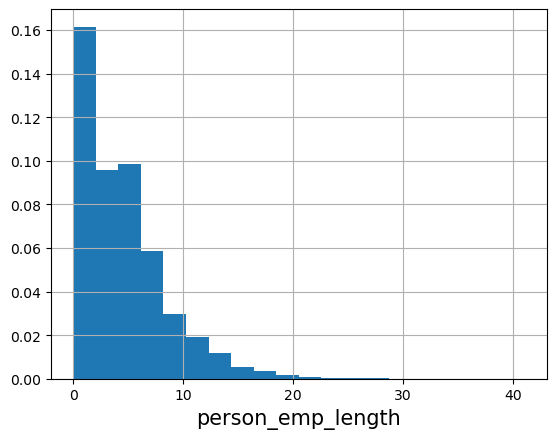

----------------------------------------------------------------------


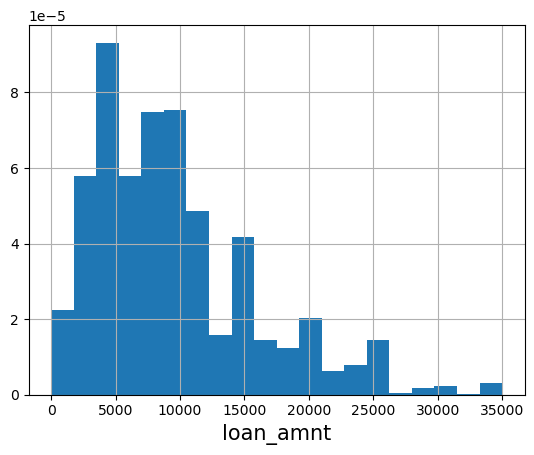

----------------------------------------------------------------------


In [27]:
for n_X_col in num_X_cols:
    df_train[n_X_col].hist(density = True, bins = 20)
    plt.xlabel(n_X_col, fontsize = 15)
    plt.show()
    print('-'*70)

### xi. Plotting every independent variable: Categorical

In [28]:
for c_X_cols in cat_X_cols:

    print('\n')
    print(f'Name column: {c_X_cols}')
    print('\n')

    print(round(df_train[c_X_cols].value_counts(normalize = True)*100, 2))

    print('\n')

    print('-'*70)



Name column: person_home_ownership


RENT        50.62
MORTGAGE    41.00
OWN          8.04
OTHER        0.34
Name: person_home_ownership, dtype: float64


----------------------------------------------------------------------


Name column: loan_intent


EDUCATION            19.70
MEDICAL              19.04
VENTURE              17.36
PERSONAL             16.90
DEBTCONSOLIDATION    15.98
HOMEIMPROVEMENT      11.02
Name: loan_intent, dtype: float64


----------------------------------------------------------------------


Name column: cb_person_default_on_file


N    82.29
Y    17.71
Name: cb_person_default_on_file, dtype: float64


----------------------------------------------------------------------


Name column: loan_grade


A    32.76
B    32.37
C    19.95
D    11.07
E     2.86
F     0.81
G     0.17
Name: loan_grade, dtype: float64


----------------------------------------------------------------------


### xii. Relation between numerical independent variables (Spearman)

In [29]:
X_train_num = X_train[num_X_cols].copy()
X_train_num = X_train_num.rank(method = 'first', ascending = True)

In [30]:
m_corr_num = round(abs(X_train_num.corr())*100, 2)

In [31]:
m_corr_num.style.background_gradient(cmap='coolwarm')

,person_age,person_income,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_emp_length,loan_amnt
person_age,100.000000,14.080000,4.600000,80.530000,1.280000,10.070000,7.020000
person_income,14.080000,100.000000,36.330000,8.990000,4.290000,20.480000,40.040000
loan_percent_income,4.600000,36.330000,100.000000,2.650000,11.810000,4.860000,65.500000
cb_person_cred_hist_length,80.530000,8.990000,2.650000,100.000000,1.900000,7.360000,4.880000
loan_int_rate,1.280000,4.290000,11.810000,1.900000,100.000000,6.450000,9.620000
person_emp_length,10.070000,20.480000,4.860000,7.360000,6.450000,100.000000,11.120000
loan_amnt,7.020000,40.040000,65.500000,4.880000,9.620000,11.120000,100.000000


In [32]:
var_corr_num = []

for c in num_X_cols:
    corr_c = list(m_corr_num[m_corr_num[c] > 70][c].index)
    for c_j in corr_c:
        if c_j != c:
            if (([c, c_j] in var_corr_num) == False) and (([c_j, c] in var_corr_num) == False):
                var_corr_num.append([c, c_j])

In [33]:
var_corr_num

[['person_age', 'cb_person_cred_hist_length']]

In [34]:
dict_anova

{'person_age': {'F': 5.89152274498991, 'p_value': 1.522291301410672},
 'person_income': {'F': 555.5803720664836, 'p_value': 1.1102230246251565e-14},
 'loan_percent_income': {'F': 3207.083218966495,
  'p_value': 1.1102230246251565e-14},
 'cb_person_cred_hist_length': {'F': 1.6773584410227746,
  'p_value': 19.52911204904244},
 'loan_int_rate': {'F': 2177.437627268028, 'p_value': 1.1102230246251565e-14},
 'person_emp_length': {'F': 143.2165788854713,
  'p_value': 1.1102230246251565e-14},
 'loan_amnt': {'F': 198.99123983943625, 'p_value': 1.1102230246251565e-14}}

**Comments:** We select "person_age" variable.

### xiii. Relation between categorical independent variables (Chi-Square)

In [35]:
for c_X_col_1 in cat_X_cols:
    for c_X_col_2 in cat_X_cols:
        print('Variable 1:', c_X_col_1)
        print('Variable 2:', c_X_col_2)
        T_part, p_value_part = chi_test(c_X_col_1, c_X_col_2)
        print('p_value:', round(p_value_part*100, 2))
        print('-'*70)

Variable 1: person_home_ownership
Variable 2: person_home_ownership
p_value: 0.0
----------------------------------------------------------------------
Variable 1: person_home_ownership
Variable 2: loan_intent
p_value: 0.0
----------------------------------------------------------------------
Variable 1: person_home_ownership
Variable 2: cb_person_default_on_file
p_value: 0.0
----------------------------------------------------------------------
Variable 1: person_home_ownership
Variable 2: loan_grade
p_value: 0.0
----------------------------------------------------------------------
Variable 1: loan_intent
Variable 2: person_home_ownership
p_value: 0.0
----------------------------------------------------------------------
Variable 1: loan_intent
Variable 2: loan_intent
p_value: 0.0
----------------------------------------------------------------------
Variable 1: loan_intent
Variable 2: cb_person_default_on_file
p_value: 27.45
----------------------------------------------------------

### xiv. Encoding

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import JamesSteinEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [37]:
cat_str_steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNKNOWN')),
    ('encoding', JamesSteinEncoder())
]

cat_str_transformer = Pipeline(steps = cat_str_steps)

In [38]:
cat_str_transformer = cat_str_transformer.fit(X_train[cat_str], y_train)

In [39]:
cat_oh_steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNKNOWN')),
    ('encoding', OneHotEncoder(handle_unknown = 'ignore'))
]

cat_oh_transformer = Pipeline(steps = cat_oh_steps)

In [40]:
cat_oh_transformer = cat_oh_transformer.fit(X_train[cat_oh])

In [41]:
cat_oh_cols = list(cat_oh_steps[1][1].get_feature_names_out())

In [42]:
new_cat_oh_cols = []

for c_oh in cat_oh_cols:

    for i in range(len(cat_oh)):

        if c_oh[1] == str(i):

            new_c_oh = cat_oh[i] + c_oh[2:]
            new_cat_oh_cols.append(new_c_oh)

In [43]:
new_cols = cat_str + new_cat_oh_cols

In [44]:
X_train_new = pd.concat(
    [
     cat_str_transformer.transform(X_train[cat_str]),
     pd.DataFrame.sparse.from_spmatrix(cat_oh_transformer.transform(X_train[cat_oh]))
    ],
    axis = 1
    )

In [45]:
X_train_new.columns = new_cols

In [46]:
X_train = X_train.reset_index()
X_train = X_train.drop(columns = ['index'])

y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])
y_train = y_train['loan_status']

In [47]:
num_X_cols.remove('cb_person_cred_hist_length')

In [48]:
X_train = pd.concat([X_train[num_X_cols], X_train_new], axis = 1)

In [49]:
X_train

,person_age,person_income,loan_percent_income,loan_int_rate,person_emp_length,loan_amnt,person_home_ownership,loan_intent,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,31,26010,0.25,9.99,2.0,0.0,0.138554,0.204087,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,26,114000,0.05,10.00,4.0,6000.0,0.138554,0.254383,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,52500,0.38,10.37,2.0,20000.0,0.297036,0.254383,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,21,47000,0.11,8.90,2.0,5400.0,0.138554,0.251120,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23,33000,0.33,7.66,0.0,11000.0,0.297036,0.260114,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19543,27,25200,0.10,14.27,0.0,2550.0,0.297036,0.251120,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19544,25,49000,0.14,6.99,9.0,7000.0,0.138554,0.204087,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19545,36,69000,0.36,14.59,0.0,25000.0,0.297036,0.254383,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19546,25,46000,0.43,16.70,0.0,19750.0,0.088234,0.260114,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### xv. NEW Relation dependent variable with independent: Numerical (ANOVA)

In [50]:
num_X_cols = list(X_train.columns)

In [51]:
def anova_test(name_num_col):

    f_0 = (y_train == 0)
    f_1 = (y_train == 1)

    S_0 = X_train[f_0][name_num_col].std()
    S_1 = X_train[f_1][name_num_col].std()

    n_0 = f_0.sum()
    n_1 = f_1.sum()

    n_T = len(y_train)

    bar_x = X_train[name_num_col].mean()

    bar_x_0 = X_train[f_0][name_num_col].mean()
    bar_x_1 = X_train[f_1][name_num_col].mean()

    SS_W = (n_0 - 1)*(S_0**2) + (n_1 - 1)*(S_1**2)
    SS_B = n_0*((bar_x - bar_x_0)**2) + n_1*((bar_x - bar_x_1)**2)

    MS_W = SS_W/(n_T - 2)
    MS_B = SS_B/(2 - 1)

    F_stat = MS_B/MS_W

    cdf = scipy.stats.f.cdf(F_stat, 2 - 1, n_T - 2)
    p_value = 1 - cdf

    return F_stat, p_value

In [52]:
dict_anova = {}

for name_num_col in num_X_cols:

    try:
    
        F_col, p_col = anova_test(name_num_col)

        dict_anova[name_num_col] = {}
        dict_anova[name_num_col]['F'] = F_col
        dict_anova[name_num_col]['p_value'] = p_col*100
    
    except:

        dict_anova[name_num_col] = {}
        dict_anova[name_num_col]['F'] = 'NaN'
        dict_anova[name_num_col]['p_value'] = 'NaN'


In [53]:
dict_anova

{'person_age': {'F': 5.89152274498991, 'p_value': 1.522291301410672},
 'person_income': {'F': 555.5803720664836, 'p_value': 1.1102230246251565e-14},
 'loan_percent_income': {'F': 3207.083218966495,
  'p_value': 1.1102230246251565e-14},
 'loan_int_rate': {'F': 2177.437627268028, 'p_value': 1.1102230246251565e-14},
 'person_emp_length': {'F': 143.2165788854713,
  'p_value': 1.1102230246251565e-14},
 'loan_amnt': {'F': 198.99123983943625, 'p_value': 1.1102230246251565e-14},
 'person_home_ownership': {'F': 1202.461985354576,
  'p_value': 1.1102230246251565e-14},
 'loan_intent': {'F': 320.03221634658513, 'p_value': 1.1102230246251565e-14},
 'cb_person_default_on_file_N': {'F': 'NaN', 'p_value': 'NaN'},
 'cb_person_default_on_file_Y': {'F': 'NaN', 'p_value': 'NaN'},
 'loan_grade_A': {'F': 'NaN', 'p_value': 'NaN'},
 'loan_grade_B': {'F': 'NaN', 'p_value': 'NaN'},
 'loan_grade_C': {'F': 'NaN', 'p_value': 'NaN'},
 'loan_grade_D': {'F': 'NaN', 'p_value': 'NaN'},
 'loan_grade_E': {'F': 'NaN', 'p_

### xvi. NEW Relation between numerical independent variables (Spearman)

In [54]:
X_train_num = X_train[num_X_cols].copy()
X_train_num = X_train_num.rank(method = 'first', ascending = True)

In [55]:
m_corr_num = round(abs(X_train_num.corr())*100, 2)

In [56]:
m_corr_num.style.background_gradient(cmap='coolwarm')

,person_age,person_income,loan_percent_income,loan_int_rate,person_emp_length,loan_amnt,person_home_ownership,loan_intent,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
person_age,100.000000,14.080000,4.600000,1.280000,10.070000,7.020000,1.030000,9.760000,5.140000,5.980000,3.470000,4.140000,5.850000,6.530000,7.320000,7.670000,7.740000
person_income,14.080000,100.000000,36.330000,4.290000,20.480000,40.040000,20.670000,0.860000,2.500000,1.300000,3.620000,1.340000,2.230000,1.980000,1.000000,1.040000,0.710000
loan_percent_income,4.600000,36.330000,100.000000,11.810000,4.860000,65.500000,10.190000,0.840000,0.280000,4.900000,6.950000,4.770000,2.610000,7.080000,5.400000,4.580000,4.060000
loan_int_rate,1.280000,4.290000,11.810000,100.000000,6.450000,9.620000,11.840000,1.460000,31.070000,33.790000,61.580000,0.760000,30.360000,25.640000,8.450000,3.300000,1.630000
person_emp_length,10.070000,20.480000,4.860000,6.450000,100.000000,11.120000,15.910000,2.570000,7.850000,3.230000,9.390000,4.980000,2.570000,5.310000,7.180000,7.990000,8.410000
loan_amnt,7.020000,40.040000,65.500000,9.620000,11.120000,100.000000,5.720000,1.720000,1.440000,3.780000,5.250000,5.300000,0.520000,5.380000,5.540000,4.570000,3.810000
person_home_ownership,1.030000,20.670000,10.190000,11.840000,15.910000,5.720000,100.000000,12.850000,26.070000,33.690000,14.290000,25.560000,32.980000,36.580000,40.700000,41.790000,42.180000
loan_intent,9.760000,0.860000,0.840000,1.460000,2.570000,1.720000,12.850000,100.000000,12.420000,13.390000,9.120000,9.960000,12.350000,15.550000,16.840000,17.760000,17.920000
cb_person_default_on_file_N,5.140000,2.500000,0.280000,31.070000,7.850000,1.440000,26.070000,12.420000,100.000000,12.560000,56.290000,55.740000,31.540000,47.680000,65.360000,69.890000,71.070000
cb_person_default_on_file_Y,5.980000,1.300000,4.900000,33.790000,3.230000,3.780000,33.690000,13.390000,12.560000,100.000000,20.720000,20.420000,70.810000,69.540000,69.340000,69.670000,70.190000


In [57]:
var_corr_num = []

for c in num_X_cols:
    corr_c = list(m_corr_num[m_corr_num[c] > 70][c].index)
    for c_j in corr_c:
        if c_j != c:
            if (([c, c_j] in var_corr_num) == False) and (([c_j, c] in var_corr_num) == False):
                var_corr_num.append([c, c_j])

In [58]:
var_corr_num

[['cb_person_default_on_file_N', 'loan_grade_G'],
 ['cb_person_default_on_file_Y', 'loan_grade_C'],
 ['cb_person_default_on_file_Y', 'loan_grade_G'],
 ['loan_grade_D', 'loan_grade_E'],
 ['loan_grade_D', 'loan_grade_F'],
 ['loan_grade_D', 'loan_grade_G'],
 ['loan_grade_E', 'loan_grade_F'],
 ['loan_grade_E', 'loan_grade_G'],
 ['loan_grade_F', 'loan_grade_G']]

**Comments:** We wont eliminate any other variable because the only correlationated are dummy features.

### Time of execution

In [59]:
end = time.time()

In [60]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 3 seconds.
